# Chapter 4: Introduction to Asset-Liability Management

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import edhec_risk_kit as erk

# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-pastel") 

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Time value of money


### Present and future value

In general, we say that $P_{t+k}$ is the **future value (FV)** of the amount of money equal to $P_t$. Likewise, we say that 
$P_t$ is the **present value (PV)** of the amount of money $P_{t+k}$ due in the future (at time $t+k$).

$$
FV = PV(1 + R)^k
\qquad\text{and}\qquad
PV = \frac{FV}{(1 + R)^k}.
$$


### Discount rate

The factor
$$
\frac{1}{(1+R)^k}, 
$$
is called the **discount factor**.


### Cumulative present value (of future cash flows)

The **cumulative present value** (PV) of future cash flows can be calculated by summing the contributions of future values $FV_t$, i.e., the value of cash flow at time $t$. 


In general, if we **denote the future cash flows as the future values**, we have that the present value of 
a **liability** $L$ is:
$$
PV(L) = \sum_{i=1}^N \frac{FV_{t_i}}{(1+R)^{t_i}} := \sum_{i=1}^N B(t_i) L_{t_i}, 
$$
and $L_{t_i}$ denotes the future cash flow at time $t_i$, i.e., the **liability at time $t_i$**, and 
$B(t_i) := 1 / (1+R)^{t_i}$ denotes the **discount rate**.

### Funding ratio

The funding ratio is therefore a simply ratio between the value of assets I currently hold and the present value of our liability:
$$
FR = \frac{\text{assets values}}{{PV(L)}}.
$$
If the value of my current assets is bigger than $PV(L)$, then $FR >1$ and this means that I have enough funds to pay of my liability in the coming future. In the example above:

In [2]:
# Example calculating discounted value
erk.discount_simple(10, .03)

0.7440939148967249

In [3]:
# Example calculating present value
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])
erk.pv_simple(liabilities, 0.03)

6.233320315080045

We can now compute the funding ratio, based on current asset values:

In [4]:
# Example calculating the funding ration
erk.funding_ratio_simple(5, liabilities, 0.03)

0.8021407126958777

Thus, in order to be able to meet the future liabilities as specified in `liabilities` at the indicated future times, the present funding ratio should be 80.2% (6.23 million in current assets in order to pay 7 million at years 3, 3.5, 4, and 4.5).

As the widget below shows, even if your assets do not go down in value, cash can be a risky asset if you think about the funding ratio rather than the asset value. Even though cash is a "safe asset" in the sense that the asset value does not go down, cash can be a very risky asset because the value of the liabilities goes up when interest rates go down. Therefore, if you think about your savings in terms of funding ratio (i.e. how much money do you have compared to what you need) then cash is a risky asset and can result in a decline in your funding ratio.

In [5]:
def show_funding_ratio(assets, r):
    fr = erk.funding_ratio_simple(assets, liabilities, r)
    print(f'{fr*100:.2f}%')
    
controls = widgets.interactive(show_funding_ratio,
                                   assets=widgets.IntSlider(min=1, max=10, step=1, value=5),
                                   r=(0, .20, .01)
)
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

### Nominal rate and Effective annual interest rate


#### Short-rate v.s. Long-Rate (annualized)

In general, given a **nominal interest rate** $r$ (also called **instantaneous interest rate**) and $N$ **number of periods**, i.e., the number of payments (of the investment, loan, and so on), 
the total return is given by:
$$
R = \left(1 + \frac{r}{N}\right)^N - 1.
$$
Such $R$ is nothing but that the **annualized return** (as we used to call it so far) or the **effective annual interest rate** 
obtained from **discrete compounding**. 

Note that, from formula above, we also have:
$$
r = N((1+R)^{1/N}-1).
$$

In [6]:
# Consider a nominal interest rate of 10% and monthly payments
nominal_rate = 0.1
periods_per_year = 12

# that is, every month, we have the following rates
rets = pd.DataFrame( [nominal_rate/periods_per_year for i in range(10)] )
rets.head(3)

,0
0,0.008333
1,0.008333
2,0.008333


Due to compounding, we have:

In [7]:
ann_ret = erk.annualize_rets(rets, periods_per_year)[0]
ann_ret

0.1047130674412966

In [8]:
R = (1 + nominal_rate / periods_per_year)**periods_per_year - 1
R

0.10471306744129683

Notice that we got, obviously, the same number (and that it does not depend on the number of returns in the dataframe...). 

#### Continuous compounding
By having the annualized return expressed in the form above, we realize that when $N$ becomes large we have:
$$
\lim_{N\to \infty} \left(1 + \frac{r}{N} \right)^N = e^{r}, 
$$
and then 
$$
R = \lim_{N\to \infty} \left(1 + \frac{r}{N} \right)^N  - 1 \approx e^r - 1
\quad\text{from which}\quad 
r \approx \log{(1 + R)}.
$$
This is the case of continuosly compounded returns. Of course it is a theoretical way of compounding although in some cases it can effectively be used. 

## CIR model: simulate changes in interest rates

The **CIR model** (from **Cox, Ingersoll, Ross**) is used to simulate changes in interest rates (returns) and it is an extension of the **Vasicek** model to prevent negative interest rates. It is a type of **one factor model**, or **short-rate model**, 
as it describes interest rate movements as driven by only one source of market risk. 
The model can be used in the valuation of interest rate derivatives. 

The dynamic for interest rates is modelled in the following way:
$$
dr_t = a(b-r_t)dt + \sigma\sqrt{r_t}dW_t,
$$
where, $W_t$ is a Brownian motion (see Week 3) which models the random market risk factor, $b$ is a **(long-term) mean interest rate**, and the difference $b-r_t$ denotes how far away is the current interest rate from the (long-term) mean interest rate. 
Finally, $a$ is the **mean-reversion speed**, or speed of adjustment to the mean, which models **how fast** do we revert to the (long-term) mean interest rate.

The movements of the interest rates then depend on the long-term mean rate ($b$) and on 
how fast the dynamic changes and try to get close to the mean rate (by $a$) after deviations 
(by the noise given by $\sigma\sqrt{r_t}dW_t$). 
Note that the standard deviation factor $\sigma\sqrt{r_t}$ avoids the possibility of negative interest rates for all positive values of $a$ and $b$. Moreover, an interest rate equal to zero is also precluded if $2ab\geq \sigma^2$. 

More generally, when the rate $r_t$ is close to zero, the standard deviation $\sigma\sqrt{r_t}$ also becomes very small, which dampens the effect of the random shock on the rate. Consequently, in this case, the evolution of the rate becomes dominated by the drift factor 
which pushes the rate upwards (towards equilibrium).

In [9]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    rates, prices = erk.cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)
    rates.plot(legend=False, figsize=(12,5))
    
import ipywidgets as widgets
from IPython.display import display
    
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

### Using the CIR model for zero-coupon bond pricing

Under the **no-arbitrage assumption**, a **zero-coupon bond** may be priced using the interest rate process modeled by the CIR model. 
The bond price $P(t,T)$ of a zero-coupon bond with maturity $T$ is exponential affine in the interest rate and is given by:
$$
P(t,T) = A(t,T)e^{-B(t,T)r_t}, 
$$
where
$$
\begin{align}
A(t,T) &:= \left( \frac{ 2h e^{(a+h)\tau/2}  }{ 2h+(a+h)(e^{h\tau}-1) }   \right)^{2ab/\sigma^2}, \\
B(t,T) &:= \frac{ 2(e^{h\tau} - 1)  }{ 2h+(a+h)(e^{h\tau}-1) },  \\
h &:= \sqrt{a^2 + 2\sigma^2}, \\
\tau &:= T - \tau.
\end{align}
$$

In [10]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    rates, prices = erk.cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)
    prices.plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

## Liability hedging 

Since we have a model to simulate interest rates and changes in the price of **zero-coupon bonds** 
we can see what happens to the hedging strategy **in case we use zero-coupon bonds as hedge instead of cash**. 

We have seen that changes in interest rates has enormous impact on the liabilities we may have for the next future, and therefore, on the funding ratios. Hence it makes sense to make sure that we know how the portfolio is going to behave as interest rates 
fluctuate over time.

The problem is: **we have some liability to satisfy in the future**, and as long as interest rates changes over times, we have to make sure to meet such a liability by using **a hedging strategy so that an increase in value of our asset will be enough**. 

Suppose we have an initial amount of $0.75$ million dollars (**asset_0**) and that we have a total liability of $1$ million dollars (**tot_liab**) due in $10$ years. Also, suppose that the mean rate (the nominal rate of this liability) is $3\%$. 

In [11]:
asset_0  = 0.75
tot_liab = 1

mean_rate = 0.03
n_years   = 10
n_scenarios = 10
periods_per_year = 12

#### Simulate interest rates and zero-coupon bond prices

Let us simulate interest rates (starting from the mean rate) for the next 10 years:

In [12]:
rates, zcb_price = erk.cir(n_years = n_years, n_scenarios=n_scenarios, a=0.05, b=mean_rate, sigma=0.05, steps_per_year=periods_per_year, r_0=None)
rates.head()

,0,1,2,3,4,5,6,7,8,9
0,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000
1,0.028165,0.028005,0.030299,0.031990,0.036443,0.028973,0.028212,0.033255,0.028259,0.026916
2,0.028296,0.025840,0.025398,0.030777,0.037804,0.026168,0.027304,0.032058,0.028396,0.023719
3,0.028608,0.025834,0.023380,0.026306,0.042634,0.027257,0.024778,0.033020,0.031160,0.025055
4,0.031451,0.021008,0.023884,0.031299,0.043318,0.024576,0.025532,0.033847,0.029760,0.021532


Furthermore, let us suppose that **our liabilities over time are given by the zero-coupon bond prices** that we have just simulated. 
This is going to be simply a trick to have changes in the liability according to the change in interest rates:

In [13]:
L = zcb_price
L.head()

,0,1,2,3,4,5,6,7,8,9
0,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590,0.749590
1,0.761536,0.762436,0.749664,0.740405,0.716640,0.757016,0.761274,0.733568,0.761007,0.768585
2,0.762499,0.776356,0.778879,0.748782,0.711428,0.774489,0.768060,0.741808,0.761939,0.788553
3,0.762466,0.778036,0.792108,0.775360,0.688948,0.770000,0.784057,0.738422,0.748452,0.782470
4,0.748644,0.807518,0.790797,0.749465,0.687566,0.786835,0.781391,0.735830,0.757839,0.804441


#### Hedging by buying zero-coupon bonds

Our task is meet the liability in 10 years. **The idea is to invest our current asset in a zero-coupon bond**. 

We know what is the price of a zero-coupon bond that matures in 10 years. Since, by definition, **such bond does not pay coupons and simply returns at maturity the face value plus the given interest**, its price is simply given by the present value of this last amount:

In [14]:
# price of a zcb with maturity 10 years and rate equal to the mean rate
zcb = pd.DataFrame(data=[tot_liab], index=[n_years])
zcb_price_0 = erk.pv_simple( zcb, mean_rate )
zcb_price_0

0    0.744094
dtype: float64

i.e., a zero-coupon bond paying off $1$ million dollars plus an interest of $3\%$ in 10 years is worth about $0.74$ million dollars today. 

Hence, **suppose we invest into such zero-coupon bond**. 
First of all, given our initial asset, we can buy today the following number of bonds:

In [15]:
n_bonds = float(asset_0 / zcb_price_0)
n_bonds

1.0079372845080916

so basically, $1$ such bond, and since we know how interest rates will change over time, 
we also know **the future value of our asset that have been invested in this zero-coupon bond**. 
In fact, we know how many bonds we buy and how the price will change. Then:

In [16]:
asset_value_of_zcb = n_bonds * zcb_price
asset_value_of_zcb.head()

,0,1,2,3,4,5,6,7,8,9
0,0.755540,0.755540,0.755540,0.755540,0.755540,0.755540,0.755540,0.755540,0.755540,0.755540
1,0.767580,0.768488,0.755615,0.746282,0.722328,0.763025,0.767316,0.739390,0.767047,0.774685
2,0.768552,0.782518,0.785061,0.754725,0.717074,0.780636,0.774157,0.747696,0.767986,0.794812
3,0.768518,0.784212,0.798395,0.781514,0.694417,0.776111,0.790281,0.744283,0.754392,0.788680
4,0.754587,0.813927,0.797074,0.755414,0.693024,0.793081,0.787593,0.741671,0.763854,0.810826


#### Hedging by investing in cash 
Suppose now that instead of putting our money in zero-coupon bonds **we just put our money in cash**. 
What is the future value of our asset then? 

Since interest changes over time, the future value of our asset is simply obtained by compounding with respect to the interest rates, i.e.,
$$
\text{asset}_{10y} = \text{asset}_0 (1+r_{0,1})(1+r_{1,2})\cdots.
$$

In [17]:
# we have to divide by periods_per_year since rates are returned as annual rates
asset_value_in_cash = asset_0 * (1 + rates/periods_per_year).cumprod()
asset_value_in_cash.head()

,0,1,2,3,4,5,6,7,8,9
0,0.751875,0.751875,0.751875,0.751875,0.751875,0.751875,0.751875,0.751875,0.751875,0.751875
1,0.753640,0.753630,0.753773,0.753879,0.754158,0.753690,0.753643,0.753959,0.753646,0.753561
2,0.755417,0.755252,0.755369,0.755813,0.756534,0.755334,0.755357,0.755973,0.755429,0.755051
3,0.757218,0.756878,0.756841,0.757470,0.759222,0.757050,0.756917,0.758053,0.757391,0.756627
4,0.759202,0.758203,0.758347,0.759445,0.761963,0.758600,0.758528,0.760191,0.759269,0.757985


#### Result: comparing the two investments

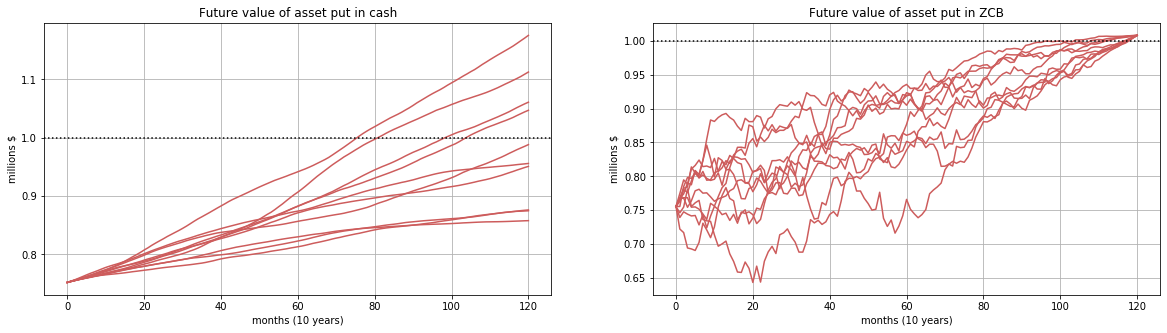

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

asset_value_in_cash.plot(ax=ax[0], grid=True, legend=False, color="indianred", title="Future value of asset put in cash")
asset_value_of_zcb.plot(ax=ax[1], grid=True, legend=False, color="indianred", title="Future value of asset put in ZCB")
ax[0].axhline(y=1.0, linestyle=":", color="black")
ax[1].axhline(y=1.0, linestyle=":", color="black")
ax[0].set_ylabel("millions $")
ax[1].set_ylabel("millions $")
if periods_per_year == 12:
    ax[0].set_xlabel("months ({:.0f} years)".format((len(asset_value_in_cash.index)-1)/periods_per_year))
    ax[1].set_xlabel("months ({:.0f} years)".format((len(asset_value_in_cash.index)-1)/periods_per_year))

plt.show()

We see that, although the increase in value in the left-hand side plot is smoother, there have been **some scenarios in which the investment of our asset value in cash did not provide the $1$ million dollars of liability** that we have to pay.

On the other hand, notheless the oscillation in value, the investment in **the zero-coupon bond always guarantee the money we need at the maturity**.

Let us look at the **funding ratios** of the two investments, that is, the ratio between the asset value and the liability:

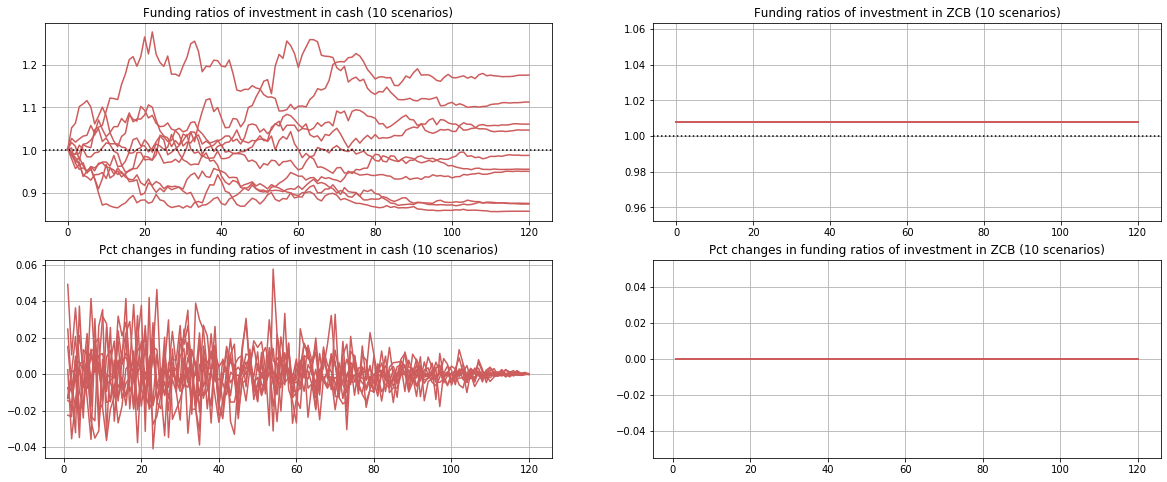

In [19]:
fr_cash = asset_value_in_cash / L
fr_zcb  = asset_value_of_zcb  / L

fig, ax = plt.subplots(2,2,figsize=(20,8))

fr_cash.plot(ax=ax[0,0], grid=True, legend=False, color="indianred", 
             title="Funding ratios of investment in cash ({} scenarios)".format(n_scenarios))
fr_zcb.plot(ax=ax[0,1], grid=True, legend=False, color="indianred", 
            title="Funding ratios of investment in ZCB ({} scenarios)".format(n_scenarios))

ax[0,0].axhline(y=1.0, linestyle=":", color="black")
ax[0,1].axhline(y=1.0, linestyle=":", color="black")

fr_cash.pct_change().plot(ax=ax[1,0], grid=True, legend=False, color="indianred",
                          title="Pct changes in funding ratios of investment in cash ({} scenarios)".format(n_scenarios))
fr_zcb.pct_change().plot(ax=ax[1,1], grid=True, legend=False, color="indianred", 
                         title="Pct changes in funding ratios of investment in ZCB ({} scenarios)".format(n_scenarios))
plt.show()

Let us now look at the **terminal** funding ratios, i.e., the funding ratio when maturity is met. Since we wan to plot an histogram for the distribution of the funding ratios, we repeat all the steps above for a larger number of scenarios:

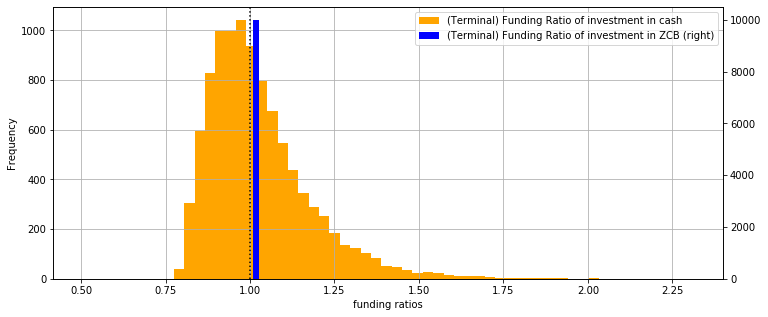

In [20]:
# simulate more scenarios
n_scenarios = 5000
rates, zcb_price = erk.cir(r_0=0.03, b=0.03, n_scenarios=10000)
# assign liabilities
L = zcb_price
# ZCB investment:
zcb = pd.DataFrame(data=[tot_liab], index=[n_years])
zcb_price_0 = erk.pv_simple( zcb, mean_rate )
n_bonds = float(asset_0 / zcb_price_0)
asset_value_of_zcb = n_bonds * zcb_price
# Cash investment 
asset_value_in_cash = asset_0 * (1 + rates/periods_per_year).cumprod()

# terminal funding ratios
terminal_fr_zcb  = asset_value_of_zcb.iloc[-1]  / L.iloc[-1]
terminal_fr_cash = asset_value_in_cash.iloc[-1] / L.iloc[-1]

ax = terminal_fr_cash.plot.hist(label="(Terminal) Funding Ratio of investment in cash", bins=50, figsize=(12,5), color="orange", legend=True)
terminal_fr_zcb.plot.hist(ax=ax, grid=True, label="(Terminal) Funding Ratio of investment in ZCB", bins=50, legend=True, color="blue", secondary_y=True)
ax.axvline(x=1.0, linestyle=":", color="k")
ax.set_xlabel("funding ratios")
plt.show()

This shows that although there are many scenarios in which we can do very well with cash, i.e., our investment in cash will gain enough value to pay the liability (funding ratios larger than $1$), **there are also many scenarios for which the funding ratio will be less than $1$**. 
On the other hand, the terminal funding ratio for the investment of zero-coupon bond will be always larger than or equal to $1$.

## Coupon-bearing bonds 

$$
\text{Bond price}= PV = \sum_{i=1}^N \left(\frac{C_{t_i}}{(1+\text{YTM})^{t_i}}\right)  +  \frac{F}{(1+\text{YTM})^{t_N}} 
= C\left(\frac{1-(1+\text{YTM})^{-t_N}}{\text{YTM}}\right) +  \frac{F}{(1+\text{YTM})^{t_N}},
$$ 
where $N$ is the number of coupons paid, 
$C_{t_i}$ is the coupon paid at time $t_i$ (they are all the same), $F$ is the face value of the bond, 
and $\text{YTM}$ is the **yield to maturity**.

For example, let us see the cash flow generated by a bond:

In [21]:
principal        = 100 
maturity         = 3
ytm              = 0.05
coupon_rate      = 0.03 
coupons_per_year = 2

In [22]:
cf = erk.bond_cash_flows(principal=principal, maturity=maturity, coupon_rate=coupon_rate, coupons_per_year=coupons_per_year)
cf

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

Since the bond pays two coupons per year, the yield of each payment is $0.015$ (half of the coupon rate), and there a total of $6$ payments where the last one (at maturity) consists of the face value plus the last coupon. 

Look at the price of such bond:

In [23]:
bond_price = erk.bond_price(principal=principal, maturity=maturity, coupon_rate=coupon_rate, coupons_per_year=coupons_per_year, discount_rate=ytm)
bond_price

0    94.491875
dtype: float64

In [24]:
# total sum paid by the bond if held until maturity 
tot_bond_paym = cf.sum()
tot_bond_paym

109.0

In [25]:
# gain (in money) of the investment in such bond
gain = -bond_price + tot_bond_paym
gain

0    14.508125
dtype: float64

Basically, the $\text{YTM}=0.05$ is **approximately** given by the annual rate which (after compounding) returns a total amount equal 
to **tot_bond_paym** by having investing an initial amount equal to the bond price **bond_price**, i.e, 

In [26]:
# tot_bond_paym = bond_price * (1 + r)**maturity, hence 
r = (tot_bond_paym / bond_price )**(1/maturity) - 1
r

0    0.048763
dtype: float64

### Relation between yield to maturity and bond price

When the price of the bond is less than its face value (par value), the bond is selling **at a discount**. This happens **when the ytm is larger than the coupon rate**.

Conversely, if the price of the bond is greater than its face value, the bond is selling **at a premium**. This happens **when the ytm is smaller than the coupon rate**.

If the price of the bond is equal to its face value, the bond is selling **at par**. This happens **when the ytm is equal to the coupon rate**.

Therefore, **the ytm and the bond price is inversely correlated**:

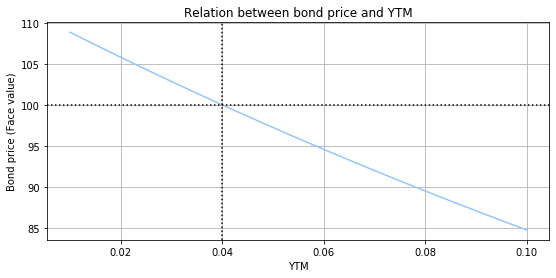

In [27]:
coupon_rate = 0.04
principal = 100
ytm = np.linspace(0.01, 0.10, 20)
bond_prices = [erk.bond_price(maturity=3, principal=principal, coupon_rate=coupon_rate, coupons_per_year=2, discount_rate=r) for r in ytm]

ax = pd.DataFrame(bond_prices, index=ytm).plot(grid=True, title="Relation between bond price and YTM", figsize=(9,4), legend=False)
ax.axvline(x=coupon_rate, linestyle=":", color="black")
ax.axhline(y=principal, linestyle=":", color="black")
ax.set_xlabel("YTM")
ax.set_ylabel("Bond price (Face value)")
plt.show()

### Changes in price 
Note that the yield to maturity is a variable that changes over time. 
In fact, it is an interest rate which changes and, in turn, would change the price of the bond. 

Let us see how the price of a coupon-bearing bond changes as interest rates (i.e., yields to maturity) change. 
First of all, we simulate the interest rates usig the CIR model:

In [28]:
n_years          = 10
n_scenarios      = 10
b                = 0.03
periods_per_year = 2

rates, _ = erk.cir(n_years = n_years,
                   n_scenarios = n_scenarios, 
                   a=0.02, b=b, sigma=0.02, 
                   steps_per_year=periods_per_year, r_0=None)

rates.tail()

,0,1,2,3,4,5,6,7,8,9
16,0.037043,0.040193,0.030664,0.021603,0.029000,0.027987,0.018957,0.034850,0.041235,0.034333
17,0.037899,0.039572,0.029428,0.020945,0.032154,0.027612,0.019966,0.034022,0.040346,0.033315
18,0.032321,0.041663,0.029547,0.019413,0.033422,0.023563,0.018505,0.036793,0.037298,0.029237
19,0.030720,0.042580,0.028842,0.019174,0.035477,0.026284,0.017990,0.036412,0.033271,0.032621
20,0.025919,0.038572,0.029164,0.018554,0.030516,0.026593,0.020491,0.034159,0.032685,0.036300


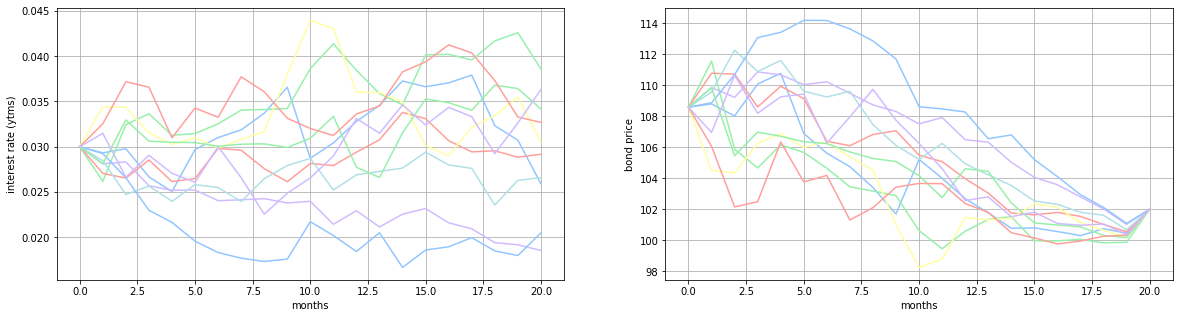

In [29]:
# bond features
principal        = 100
maturity         = n_years
coupon_rate      = 0.04
coupons_per_year = periods_per_year

bond_prices = erk.bond_price(principal=principal, maturity=maturity, coupon_rate=coupon_rate, 
                             coupons_per_year=coupons_per_year, discount_rate=rates) 

fig, ax = plt.subplots(1,2,figsize=(20,5))
rates.plot(ax=ax[0], grid=True, legend=False) 
bond_prices.plot(ax=ax[1], grid=True, legend=False)
ax[0].set_xlabel("months")
ax[0].set_ylabel("interest rate (ytms)")
ax[1].set_xlabel("months")
ax[1].set_ylabel("bond price")
plt.show()

On the left, we see how interest rates changes over time, and on the right, we see how, in turn, the bond price changes as well.
Also notice that, the price of the bonds at maturity is the same in all scenarios as it is given by the principal plus the coupon-interest. 

## Macaulay Duration 

The **Macaulay duration** is the **weighted average maturity of cash flows**. Suppose the case of a bond. We have a set 
of fixed cash flows (the coupon payments and the last payment given by the principal) whose total present value is given by
$$
PV = \sum _{i=1}^{N} PV_{i}.
$$
Hence, the Macaulay duration is defined as
$$
\text{MacD} 
:= \frac{ \sum_{i=1}^N t_i PV_i}{ \sum _{i=1}^{N} PV_{i} } 
= \frac{ \sum_{i=1}^N t_i PV_i}{PV} 
= \sum_{i=1}^N w_i t_i
\quad\text{with}\quad
w_i := \frac{PV_i}{PV}, 
$$
where $PV_{i}$ is the present value of the cash flow paid at time $t_i$. 
Note that **the Macaulay duration of a zero-coupon bond is equal to the maturity** as such a bond does not pay regular coupons 
but only one single payment at maturity.

In [30]:
principal        = 1000
maturity         = 3
ytm              = 0.06
coupon_rate      = 0.06
coupons_per_year = 2
cf = erk.bond_cash_flows(principal=principal, maturity=maturity, coupon_rate=coupon_rate, coupons_per_year=coupons_per_year)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [31]:
# the discount rate is the YTM divided by the coupons_per_year
macd = erk.macaulay_duration(cf, discount_rate=ytm/coupons_per_year) 
macd = macd / coupons_per_year
macd

2.789853593597267

that is, the duration of the bond is about $2.79$ years versus the real maturity of $3$ years. **Note that we have divided by the number of coupons per year** because the returned duration was computed with dates from 1 to 6, hence it was about $5.57$ 
(this is the duration expressed in the number of total *periods*). 

Another way to compute the duration would be to **normalize the cash flows dates**:

In [32]:
cf = erk.bond_cash_flows(principal=principal, maturity=maturity, coupon_rate=coupon_rate, coupons_per_year=coupons_per_year)
cf.index = cf.index / coupons_per_year
cf

0.5      30.0
1.0      30.0
1.5      30.0
2.0      30.0
2.5      30.0
3.0    1030.0
dtype: float64

In [33]:
# and now the discount rate is simply the YTM
erk.macaulay_duration(cf, discount_rate=ytm)

2.790146937449203

and note that in this case we use **only the YTM as discount rate**.

The interpretation is simply that **since the bond is paying coupons during its life, the time waited to get back the money is, effectively, less than the maturity**, just because we already receive some money during the life of the bond.

Let us verify that the duration of a zero-coupon bond is equal to the maturity, no matters the interest rate:

In [34]:
# ZCB: only one flux at maturity
maturity = 3
cf = pd.DataFrame(data=[100], index=[maturity])
macd = erk.macaulay_duration(cf, discount_rate=0.05) # it does not matter the rate here
macd

3.0

## Liability Driven Investing (LDI)



### Duration Matching

Assume we have a liability of 100K in 10 years time and another of 100K in 12 years time. Assume interest rates are 4%. What is the duration of the liabilities?

In [35]:
liabilities = pd.Series(data = [100000, 100000], index=[10, 12])
erk.macaulay_duration(liabilities, .04)

10.960799385088393

Now assume we have two types of bonds available. We have a 10 year bond and a 15 year bond. Each of them pays a 5% coupon once a year and has a face value of \\$1000. What are the durations of these bonds?

In [36]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
print(md_10)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)
print(md_20)

8.190898824083233
13.544718122145921


Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

The function `match_duration` in the `edhc_risk_kit` will do this for us.

In [37]:
# Example
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s # the weight for the short bond

0.48263092069478974

In [38]:
p_short = erk.bond_price(10, 1000, .05, 1, 0.04)
p_long = erk.bond_price(20, 1000, .05, 1, 0.04)
a_0 = 130000
dm_assets=pd.concat([a_0*w_s*short_bond/float(p_short),a_0*(1-w_s)*long_bond/float(p_long)])
erk.macaulay_duration(dm_assets, 0.04)

10.960799385088393

In [39]:
cfr = erk.funding_ratio(dm_assets, liabilities, 0.04)
cfr

0.9998760012192478

In [40]:
lb_assets = a_0*long_bond/float(p_long)
sb_assets = a_0*short_bond/float(p_short)

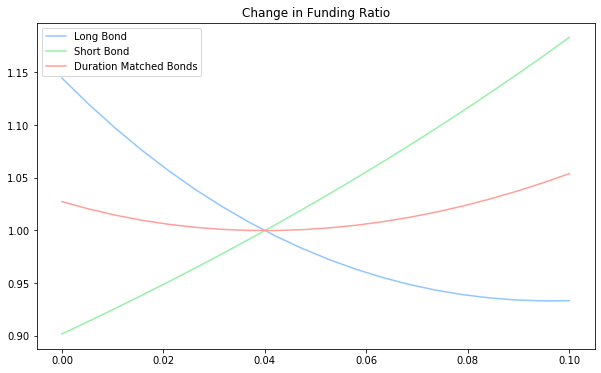

In [41]:
rates = np.linspace(0, .1, 20)
fr_change = pd.DataFrame({
    "Long Bond":[erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond":[erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds":[erk.funding_ratio(dm_assets, liabilities, r) for r in rates]
}, index=rates)
fr_change.plot(title='Change in Funding Ratio', figsize=(10,6));

# Monte Carlo Simulation of Prices of Coupon-Bearing Bond using CIR


Note that when interest rates rise, it is a fallacy that holding an allocation to bonds will give you the benefit of that increase. In fact, the opposite happens since the price of the bond will fall, and as a result your account still suffer a capital loss.

Let's examine what happens to your wealth when you use a portfolio of stocks and bonds over a 5 year period.

For simplicity, we'll assume you are holding a bond that has a maturity of 5 years and for simplicity with avoiding intra-coupon caclulations, let's assume it pays a 5% coupon and the coupon is paid out each month and interest rates change from 3% to 3.2%


In [42]:
erk.bond_price(5,100,.05,12,.03)

0    109.275393
dtype: float64

In [43]:
erk.bond_price(5,100,.05,12,.032)

0    108.306703
dtype: float64

We'll generate interest rates using the CIR model:

In [44]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)

When we start out, all rates are at 3% and so the prices are all the same:

In [45]:
erk.bond_price(5,100,.05,12, rates.iloc[0][[1,2,3]])

1    109.275393
2    109.275393
3    109.275393
dtype: float64

In [46]:
rates[[1,2,3]].head()

,1,2,3
0,0.030000,0.030000,0.030000
1,0.029594,0.029805,0.029479
2,0.025358,0.029360,0.027937
3,0.026059,0.031302,0.027284
4,0.030847,0.026302,0.026970


At t=0 interest rates are the same across all scenarios. However at the first step, we see that (i) the maturity decreases and (ii) interest rates change, and so the bond prices diverge:

In [47]:
erk.bond_price(5,100,.05,12, rates.iloc[1][[1,2,3]])

1    109.473371
2    109.370189
3    109.529463
dtype: float64

### Simulating Prices of a Coupon-bearing Bond

From the ability to compute bond prices from rates, we can stitch together the prices of a bond over time:

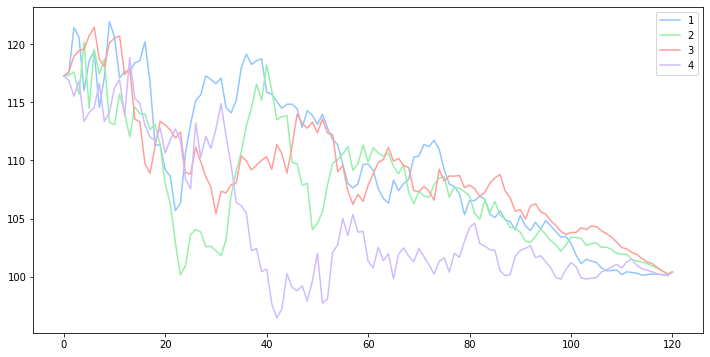

In [48]:
prices = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
prices.plot(figsize=(12,6));

In [49]:
prices.head()

,1,2,3,4
0,117.26,117.26,117.26,117.26
1,117.519,117.32,117.627,116.878
2,121.427,117.611,118.951,115.521
3,120.593,115.694,119.428,116.82
4,115.992,120.208,119.578,113.341


Because the interest rate at the time we bought the bond was less than the coupon rate, we bought it at a premium, taking a capital loss when we sold it at the end. We need to compute the Total Return of a bond, which is the price return PLUS the dividend with the function `bond_total_return`.

In [50]:
p = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
btr = erk.bond_total_return(p, 100, .05, 12)
erk.annualize_rets(btr, 12)

1    0.030583
2    0.031436
3    0.030845
4    0.032867
dtype: float64

Which gives us the approximately 3% return we expected, because that was the prevailing rate when we bought it. We also assumed that we reinvested the coupon in the bond and that is why we did not get the exact same return in each case, since we would observe prices based on the then-prevalent interest rates.

## Putting it all together: Monte Carlo Simulation of Asset Allocation

Now that we have a way to generate prices from which to derive returns, we can experiment with allocating across the different Asset Classes.

Let's start by examining the performance of a 70-30 allocation to Stocks and Bonds. Assume Stocks return an average of 7% per year with a 15% vol and use the CIR model to generate bond prices for a 10 year and 30 year bond that pays a 5% coupon. For simplicity, assume the coupon is paid monthly to avoid having to deal with partial coupons. Assume the Bond Portfolio consists of 60% in the 10 year bond and 40% in the 30 year bond.

In [51]:
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_10[[1,2,3]].tail()

,1,2,3
116,100.25,100.927,101.136
117,100.222,100.746,100.804
118,100.181,100.48,100.516
119,100.107,100.263,100.239
120,100.417,100.417,100.417


In [52]:
price_30 = erk.bond_price(30, 100, .05, 12, rates)
price_30[[1,2,3]].tail()

,1,2,3
116,110.289,145.733,159.399
117,112.251,149.813,154.863
118,115.239,147.426,151.964
119,118.23,152.933,146.842
120,121.788,152.378,141.75


In [53]:
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)

Now we can assume monthly rebalancing and compute the monthly returns of the bond portfolio:

In [54]:
rets_bonds = .6*rets_10 + .4*rets_30
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035781,0.003463,0.049481,3.727705,-0.001326,-0.000747,1.624829,0.0


In [55]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
price_eq.shape

(121, 500)

In [56]:
rets_eq = price_eq.pct_change().dropna()
rets_eq.shape

(120, 500)

In [57]:
rets_bonds.shape

(120, 500)

Now we assume a 70/30 Equity/Debt portfolio where the equity is simulated by geometric brownian motion and the debt portfolio is the 60/40 short-long bond portfolio simulated using CIR model:

In [58]:
rets = .70*rets_eq + 0.3*rets_bonds
rets_mean = rets.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.061882,0.005007,-0.066389,2.594904,-0.002611,-0.002064,6.19763,0.0


## Naive Risk Budgeting Strategies between PSP and GHP


### The Simplest Allocator - Fixed Mix

The allocator's job is to come up with a time series of weights, so let's create the simplest possible allocator - one that puts a fixed fraction in the first portfolio and the remaining in the second


```python

def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)
```

We are now ready to rerun the experiment we ran last time ... a bond portfolio of 60% in the 10 year bond and 40% in the 30 year bond to generate a fixed mix bond portfolio.

In [59]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.036183,0.00351,0.33866,2.942534,-0.001405,-0.00107,1.714282,0.0


Next, we'll use this to create a 70-30 Stock Bond Mix. First, we'll generate stock returns:

In [60]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

And next, we'll use the mix backtester to build a 70-30 Stock-Bond mix. One way to assess the performance is, as before, to generate a composite and produce summary stats on the composite. We'll also examine a second approach, which is to compute summary stats on each scenario and average the summary stats.

In [61]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.058025,0.005387,-0.491308,3.455844,-0.00197,-0.000978,5.063442,-0.000237


In [62]:
# Approach 2: compute stats on each scenario and then average
summaries = erk.summary_stats(rets_7030b)
summaries.mean()

Annualized Return          0.052518
Annualized Vol             0.107502
Skewness                  -0.008017
Kurtosis                   2.962279
Cornish-Fisher VaR (5%)    0.046191
Historic CVaR (5%)         0.058550
Sharpe Ratio               0.206047
Max Drawdown              -0.207956
dtype: float64

However, both of these summaries are imperfect, since they aggregate across a wide distribution. In different situations one or the other might make sense, but for most individuals, the range of outcomes are what matters because we observe only one of the different possible scenarios.

## Distribution of Terminal Values and Measuring Risk Budget Efficiency

The basic idea is to measure the distribution of terminal values across all scenarios.

```python
def terminal_values(rets):
    """
    Computes the terminal values from a set of returns supplied as a T x N DataFrame
    Return a Series of length N indexed by the columns of rets
    """
    return (rets+1).prod()

def terminal_stats(rets, floor = 0.8, cap=np.inf, name="Stats"):
    """
    Produce Summary Statistics on the terminal values per invested dollar
    across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column DataFrame of Summary Stats indexed by the stat name 
    """
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = breach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std" : terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short":e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats

```

In [63]:
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30")],
          axis=1)

,FI,Eq,70/30
mean,1.389056,1.916706,1.750074
std,0.112754,0.977672,0.598495
p_breach,NaN,0.042000,0.010000
e_short,NaN,0.115705,0.022186
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


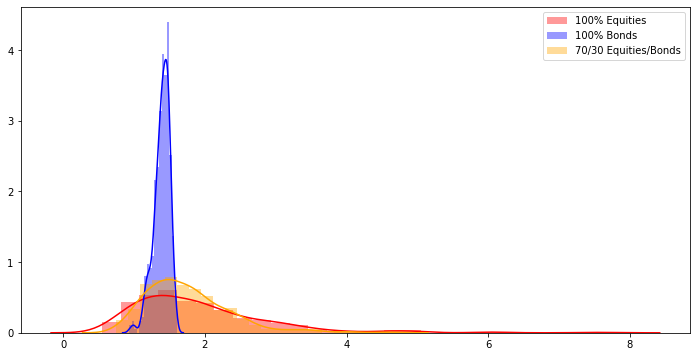

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

Note how the higher mean return of the equities portfolio is due in part to the large upside spread in equities.

## Risk Budgeting through Glide Path Allocation

A potential improvement over naive fixed mix is to risk budget by making a simplistic assumption that risk = time.

In other words, if you have more time, increase the risk budget. If you have less time, derisk. This is the thinking behind a Target Date Fund.

Let's write an allocator that defines the weights as a glidepath sthat starts at a starting weight and then gradually decreases the weights to equities over time to an ending weight. For example, you can start at 80% stocks at the start of the 10 year period and then gradually move to 20% stocks by the end of the 10 year period.

Let's see how this does:

```python
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0.0):
    """
    Allocates weights to r1 starting at start_glide and ends at end_glide
    by gradually moving from start_glide to end_glide over time
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths
```


In [65]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30"),
           erk.terminal_stats(rets_g8020, name="Glide 80 to 20")],
          axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.389056,1.916706,1.750074,1.646327
std,0.112754,0.977672,0.598495,0.420846
p_breach,NaN,0.042000,0.010000,0.002000
e_short,NaN,0.115705,0.022186,0.026068
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


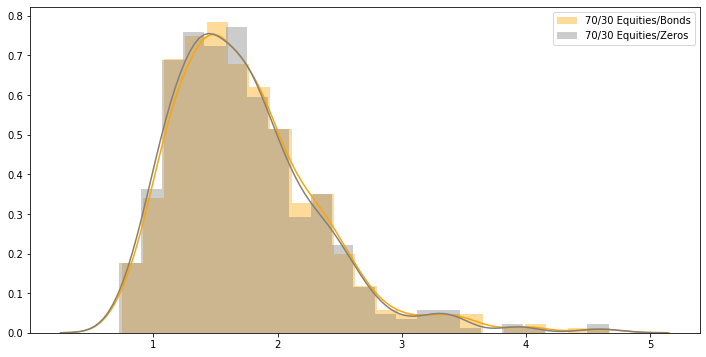

In [66]:
rets_7030z = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
plt.figure(figsize=(12, 6))
#sns.distplot(terminal_values(rets_eq), color="red", label="100% Equities")
#sns.distplot(terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
#sns.distplot(terminal_values(rets_g8020), color="green", label="Glide 80 to 20")
sns.distplot(erk.terminal_values(rets_7030z), color="grey", label="70/30 Equities/Zeros")
plt.legend();

### Conclusion

Static or Naive risk budgeting involves allocating between the PSP and GHP using either a simple fixed mix or a blind glidepath. These can reduce the downside risk but come at the cost the expected return, and cannot be used to secure a minimum acceptable level of wealth or liabilities. In the next session, we'll examine dynamic approaches that will address the challenge of meeting a set of future liabilities such as replacement income, or a required level of wealth in the future.


# Monte Carlo simulation of Dynamic Risk Budgeting between PSP and GHP

We've looked at the fundamental problem of how much to allocate in the safe asset vs the performance seeking asset, and we investigated static and glidepath based techniques. Now we'll look at modern dynamic techniques that are inspired by CPPI to ensure that the account value reaches a certain target minimum floor, but also maintains exposure to the upside through a dynamic risk budget

Let's start by building 500 scenarios for interest rates, an duration matched bond portfolio (proxied by a zero coupon bond) and a stock portfolio.

In [67]:
n_scenarios =  5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma=0.02)
price_eq = erk.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)],
          axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.98,1.77
std,0.00,0.99,0.60
p_breach,NaN,0.04,0.01
e_short,NaN,0.12,0.07
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


Let's write a new allocator that we'll call a Floor Allocator applies a dynamic risk budget to allocate more to the PSP when there is a cushion, similar to what we did for CPPI

```python
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC Prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ## PV of Floor assuming today's rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history
```


In [68]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75,  zc_prices=zc_prices[1:])
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,1.98,1.77,1.96
std,0.00,0.99,0.60,0.99
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.12,0.07,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [69]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=1)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1
mean,1.34,1.98,1.77,1.96,1.63
std,0.00,0.99,0.60,0.99,0.44
p_breach,NaN,0.04,0.01,NaN,NaN
e_short,NaN,0.12,0.07,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN


In [70]:
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=5)
rets_floor75m10 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=10)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75)
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10
mean,1.34,1.98,1.77,1.96,1.63,1.97,1.97
std,0.00,0.99,0.60,0.99,0.44,0.99,1.00
p_breach,NaN,0.04,0.01,NaN,NaN,NaN,0.03
e_short,NaN,0.12,0.07,NaN,NaN,NaN,0.00
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


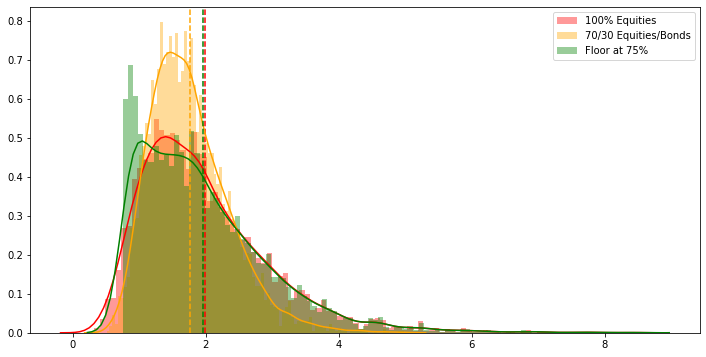

In [73]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)

plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")

plt.legend();

## Dynamic Risk Budgeting with Drawdown instead of a fixed floor

```python
def drawdown_allocator(psp_r, ghp_r, maxdd, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    ### For MaxDD
    peak_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        ### For MaxDD
        floor_value = (1-maxdd)*peak_value ### Floor is based on Prev Peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        ### For MaxDD
        peak_value = np.maximum(peak_value, account_value) ### For MaxDD
        w_history.iloc[step] = psp_w
    return w_history
```

In [74]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)           
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10,MaxDD25
mean,1.34,1.98,1.77,1.96,1.63,1.97,1.97,1.64
std,0.00,0.99,0.60,0.99,0.44,0.99,1.00,0.55
p_breach,NaN,0.04,0.01,NaN,NaN,NaN,0.03,NaN
e_short,NaN,0.12,0.07,NaN,NaN,NaN,0.00,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.2332020113012466

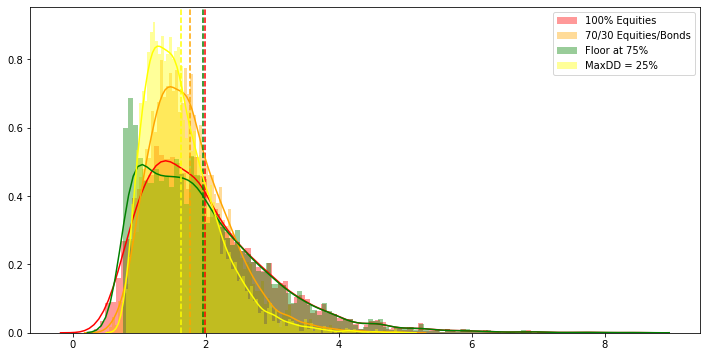

In [76]:
# Plot
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

## Backtesting Dynamic Strategies with Historical Data

Try and work with real historic data such as a the Industry Portfolios or the Total Market Index we constructed and run back tests with different parameter values. For instance:

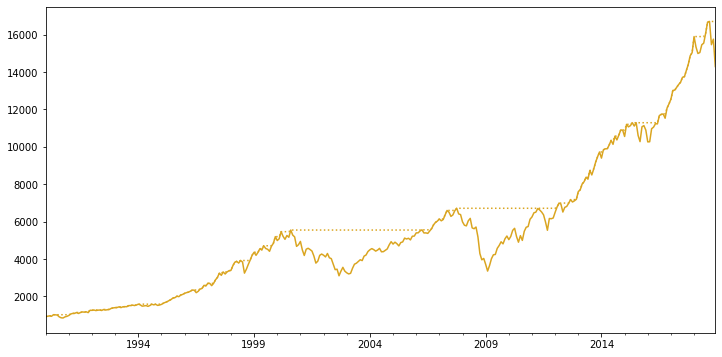

In [77]:
rets_tmi =  erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

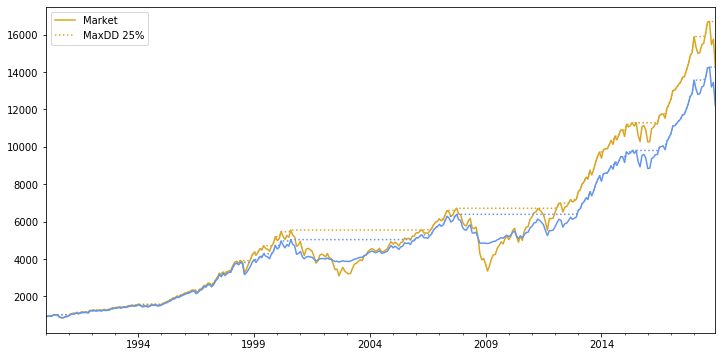

In [78]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":")

In [79]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
